In [ ]:
data_path='/content/drive/MyDrive/TrashnetDataset/dataset-resized.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch #we are using pytorch
from torch import nn #for neural networks
from torchvision import models #inbuilt models like vgg16 etc

In [ ]:
from torch import optim #optimizers to reduce loss

In [ ]:
import torchvision #for image processing
from torchvision import transforms,datasets #for image transformations or augmentations
from torch.utils.data import DataLoader,random_split, Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data_path='/content/drive/MyDrive/dataset'

In [ ]:
#data augmentation for the images in the data set
data_transforms=transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                    ])

In [ ]:
# Base transformation (applies to all images)
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Augmentations
vertical_flip = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomVerticalFlip(p=1.0),  # Always flip vertically
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

horizontal_flip = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=1.0),  # Always flip horizontally
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

rotation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(degrees=20),  # Rotate by ±20 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

color_jitter = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

grayscale = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomGrayscale(p=0.5),  # Convert to grayscale 50% of the time
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, transform_list):
        self.dataset = dataset
        self.transform_list = transform_list
        self.transform_count = len(transform_list)

    def __len__(self):
        return len(self.dataset) * self.transform_count  # Multiple augmentations

    def __getitem__(self, idx):
        img_idx = idx // len(self.transform_list)  # Get original image index
        transform = self.transform_list[idx % len(self.transform_list)]  # Apply different transforms

        image, label = self.dataset[img_idx]  # Load original image
        return transform(image), label  # Apply transformation

# List of all transformations
transform_list = [base_transform, vertical_flip, horizontal_flip, rotation, color_jitter, grayscale]


In [ ]:
#loading dataset
#we already have dataset path as data_path
image_dataset= datasets.ImageFolder(data_path)

In [ ]:
image_dataset.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
len(image_dataset)

2527

In [ ]:
# Create dataset with multiple augmented images
augmented_dataset = AugmentedDataset(image_dataset, transform_list=transform_list)

In [ ]:
train_size=int(0.8*len(augmented_dataset))
val_size=len(augmented_dataset)-train_size
print(train_size,val_size)

12129 3033


In [ ]:
train_dataset,val_dataset=random_split(augmented_dataset,[train_size,val_size])

In [ ]:
#after getting a dataset, we create a data loader
# data_loader=torch.utils.data.DataLoader(image_dataset,batch_size=4,shuffle=True)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
len(val_loader)

190

In [ ]:
# device=torch.accelerator.current_accelerator().type if torch.accelerator.is_available else 'cpu'

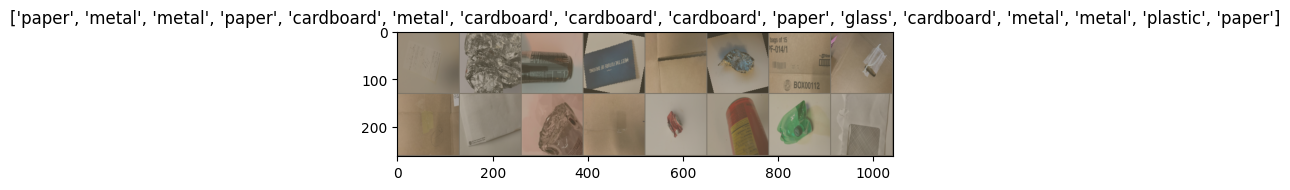

In [ ]:
def imshow(inp,title=None):
  inp=inp.numpy().transpose((1,2,0))
  mean=np.array([0.485,0.456,0.406])
  std=np.array([0.229,0.224,0.225])
  inp=std*inp+mean
  inp=np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)



image,label=next(iter(train_loader))
out=torchvision.utils.make_grid(image)
imshow(out,title=[image_dataset.classes[x] for x in label])


<p>first, we load the data set</p>
<p>then we transform the images in the data set </p>
<p>then we divide the data set into train set and validation set with 80:20 </p>
<p>then we visualize the batch of data</p>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


In [ ]:
num_features = model.fc.in_features

In [ ]:
model.fc = nn.Linear(num_features, 6)

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            running_corrects += torch.sum(preds == labels.data)

            total_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects.double() / total_train
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc.item())
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        model.eval()

        running_val_loss = 0.0
        running_val_corrects = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()

                running_val_corrects += torch.sum(preds == labels.data)

                total_val += labels.size(0)


        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_acc = running_val_corrects.double() / total_val
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(epoch_val_acc.item())

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = model.state_dict()

        scheduler.step()
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [ ]:
train_loss_list, val_loss_list, train_acc_list, val_acc_list = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25)

Epoch 0/24
Train Loss: 1.0178 Acc: 0.6245
Val Loss: 0.6440 Acc: 0.7620
Epoch 1/24
Train Loss: 0.7019 Acc: 0.7463
Val Loss: 0.7491 Acc: 0.7563
Epoch 2/24
Train Loss: 0.5262 Acc: 0.8127
Val Loss: 1.1022 Acc: 0.6841
Epoch 3/24
Train Loss: 0.4115 Acc: 0.8546
Val Loss: 0.4302 Acc: 0.8536
Epoch 4/24
Train Loss: 0.3498 Acc: 0.8763
Val Loss: 0.3019 Acc: 0.8945
Epoch 5/24
Train Loss: 0.2707 Acc: 0.9058
Val Loss: 0.2587 Acc: 0.9163
Epoch 6/24
Train Loss: 0.2626 Acc: 0.9082
Val Loss: 0.3165 Acc: 0.8928
Epoch 7/24
Train Loss: 0.0995 Acc: 0.9676
Val Loss: 0.1047 Acc: 0.9614
Epoch 8/24
Train Loss: 0.0621 Acc: 0.9814
Val Loss: 0.0976 Acc: 0.9683
Epoch 9/24
Train Loss: 0.0448 Acc: 0.9880
Val Loss: 0.0840 Acc: 0.9730
Epoch 10/24
Train Loss: 0.0414 Acc: 0.9879
Val Loss: 0.0827 Acc: 0.9720
Epoch 11/24
Train Loss: 0.0313 Acc: 0.9905
Val Loss: 0.0818 Acc: 0.9733
Epoch 12/24
Train Loss: 0.0273 Acc: 0.9927
Val Loss: 0.0817 Acc: 0.9749
Epoch 13/24
Train Loss: 0.0302 Acc: 0.9902
Val Loss: 0.0878 Acc: 0.9683
Ep

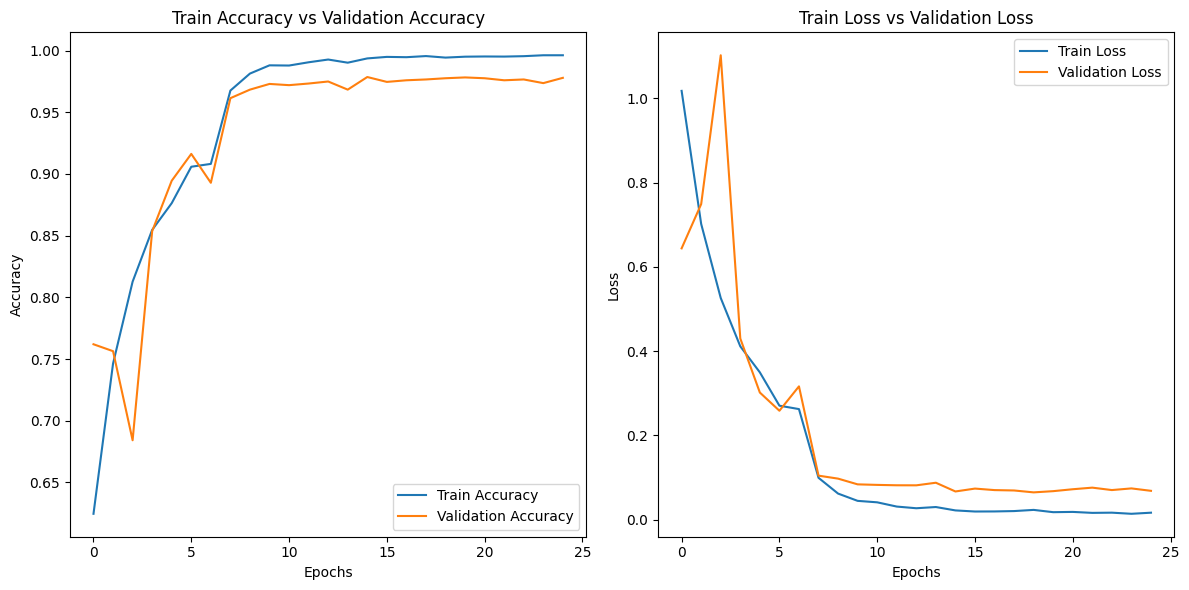

In [ ]:

# Plot 1: Train accuracy vs. Validation accuracy
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'model_weights_trained_April6.pth')

In [ ]:
#loading the model
model1 = models.resnet50(pretrained=True)
num_features1 = model1.fc.in_features
model1.fc = nn.Linear(num_features1, 6)
# model1.load_state_dict(torch.load('model_weights.pth'))
model1.load_state_dict(torch.load('model_weights_trained_April6.pth'))
model1.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the test image
image_path = "/content/drive/MyDrive/Colab Notebooks/IMG_6417.png"  # Change this to your image path
image = Image.open(image_path).convert("RGB")

# Apply transformations
image = transform(image)

# Add batch dimension (PyTorch expects batches)
image = image.unsqueeze(0)  # Shape: (1, 3, 128, 128)

# Move to device (if using GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)
image = image.to(device)

# Perform inference
with torch.no_grad():
    outputs = model1(image)
    _, predicted = torch.max(outputs, 1)  # Get class index

print(f"Predicted class: {image_dataset.classes[predicted.item()]}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/IMG_6417.png'